### Note

per l'uso delle regexp in R vedere anche [Regular expressions stringr](https://stringr.tidyverse.org/articles/regular-expressions.html)

** Algorithm Description **

TO BE DONE

**Example: Filtering Mobile Phone Spam**

***Step 1 - Exploring and Preparing the Data***

The first step towards constructing our classifier involves processing the raw data for
analysis. Text data are challenging to prepare, because it is necessary to transform the
words and sentences into a form that a computer can understand. We will transform
our data into a representation known as bag-of-words, which ignores word order and
simply provides a variable indicating whether the word appears at all. 

Data are downnloaded from [Machine-Learning-with-R-dataset](https://github.com/stedy/Machine-Learning-with-R-datasets), a complete description can be found at [SMS Spam Collection](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/).


In [3]:
# Definition of Working Folder

Dirname <- "/working/01_Machine_Learning/01_Appunti"
Dirs <- list.dirs(path=file.path("~"),recursive=T)
dir_wd <- names(unlist(sapply(Dirs,grep,pattern=Dirname))[1])
dir_wd <- paste(dir_wd,'Dati',sep='/')
setwd(dir_wd)
cat("Current working folder is ' : ", getwd())

Current working folder is ' :  C:/Users/t004314/Documents/GitHub/working/01_Machine_Learning/01_Appunti/Dati

In [4]:
sms_raw <- read.csv("sms_spam.csv", stringsAsFactors = FALSE)

In [5]:
str(sms_raw)

'data.frame':	5574 obs. of  2 variables:
 $ type: chr  "ham" "ham" "spam" "ham" ...
 $ text: chr  "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..." "Ok lar... Joking wif u oni..." "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question("| __truncated__ "U dun say so early hor... U c already then say..." ...


The type element is currently a character vector. Since this is a categorical variable, it
would be better to convert it into a factor, as shown in the following code:

In [6]:
sms_raw$type <- factor(sms_raw$type)

In [7]:
str(sms_raw$type)

 Factor w/ 2 levels "ham","spam": 1 1 2 1 1 2 1 1 2 2 ...


In [8]:
table(sms_raw$type)


 ham spam 
4827  747 

***Step 2 - Data Preparation - Cleaning and Standardizing Text Data***

SMS messages are strings of text composed of words, spaces, numbers, and
punctuation. Handling this type of complex data takes a lot of thought and
effort. One needs to consider how to remove numbers and punctuation; handle
uninteresting words such as and, but, and or; and how to break apart sentences into
individual words. 

This functionality has been provided by the members
of the R community in a text mining package titled tm. To learn more, see [Feinerer I, Hornik K, Meyer D. Text
Mining Infrastructure in R. Journal of Statistical Software. 2008; 25:1-54](https://www.jstatsoft.org/article/view/v025i05) or digit the R command `vignette("tm")`.

The tm package can be installed via the install.packages("tm") command
and loaded with the library(tm) command.


In [11]:
library(tm)

Loading required package: NLP


The first step in processing text data involves creating a corpus, which is a collection
of text documents. The documents can be short or long, from individual news
articles, pages in a book or on the web, or entire books. In our case, the corpus
will be a collection of SMS messages.

In order to create a corpus, we'll use the `VCorpus()` function in the `tm` package,
which refers to a volatile corpus—volatile as it is stored in memory as opposed to
being stored on disk (the `PCorpus()` function can be used to access a permanent
corpus stored in a database). This function requires us to specify the source of
documents for the corpus, which could be from a computer's filesystem, a database,
the Web, or elsewhere. Since we already loaded the SMS message text into R, we'll
use the `VectorSource()` reader function to create a source object from the existing
`sms_raw$text` vector, which can then be supplied to `VCorpus()` as follows:

In [12]:
sms_corpus <- VCorpus(VectorSource(sms_raw$text))

To view an actual message text, the `as.character()` function must be applied to
the desired messages. To view one message, use the `as.character()` function on
a single list element, noting that the double-bracket notation is required:

In [13]:
as.character(sms_corpus[[1]])

[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

In [14]:
lapply(sms_corpus[1:10], as.character)

$`1`
[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

$`2`
[1] "Ok lar... Joking wif u oni..."

$`3`
[1] "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

$`4`
[1] "U dun say so early hor... U c already then say..."

$`5`
[1] "Nah I don't think he goes to usf, he lives around here though"

$`6`
[1] "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv"

$`7`
[1] "Even my brother is not like to speak with me. They treat me like aids patent."

$`8`
[1] "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"

$`9`
[1] "WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."

$`10`
[1] "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030"

As noted earlier, the corpus contains the raw text of 5,559 text messages. In order
to perform our analysis, we need to divide these messages into individual words.
But first, we need to clean the text, in order to standardize the words, by removing
punctuation and other characters that clutter the result. For example, we would like
the strings Hello!, HELLO, and hello to be counted as instances of the same word.

The `tm_map()` function provides a method to apply a transformation (also known
as mapping) to a tm corpus. We will use this function to clean up our corpus using a
series of transformations and save the result in a new object called `corpus_clean`.

Our first order of business will be to standardize the messages to use only lowercase
characters. To this end, R provides a `tolower()` function that returns a lowercase
version of text strings. In order to apply this function to the corpus, we need to
use the tm wrapper function `content_transformer()` to treat `tolower()` as a
transformation function that can be used to access the corpus. The full command is
as follows:

In [15]:
sms_corpus_clean <- tm_map(sms_corpus,content_transformer(tolower))
as.character(sms_corpus[[3]])
as.character(sms_corpus_clean[[3]])

[1] "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

[1] "free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's"

In [16]:
sms_corpus_clean <- tm_map(sms_corpus_clean, removeNumbers)

In [17]:
as.character(sms_corpus[[3]])
as.character(sms_corpus_clean[[3]])

[1] "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

[1] "free entry in  a wkly comp to win fa cup final tkts st may . text fa to  to receive entry question(std txt rate)t&c's apply over's"

In [18]:
sms_corpus_clean <- tm_map(sms_corpus_clean,removeWords, stopwords())

In [19]:
stopwords(kind = "en")

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"

In [20]:
stopwords(kind = "it")

[1] "ad"         "al"         "allo"       "ai"         "agli"      
  [6] "all"        "agl"        "alla"       "alle"       "con"       
 [11] "col"        "coi"        "da"         "dal"        "dallo"     
 [16] "dai"        "dagli"      "dall"       "dagl"       "dalla"     
 [21] "dalle"      "di"         "del"        "dello"      "dei"       
 [26] "degli"      "dell"       "degl"       "della"      "delle"     
 [31] "in"         "nel"        "nello"      "nei"        "negli"     
 [36] "nell"       "negl"       "nella"      "nelle"      "su"        
 [41] "sul"        "sullo"      "sui"        "sugli"      "sull"      
 [46] "sugl"       "sulla"      "sulle"      "per"        "tra"       
 [51] "contro"     "io"         "tu"         "lui"        "lei"       
 [56] "noi"        "voi"        "loro"       "mio"        "mia"       
 [61] "miei"       "mie"        "tuo"        "tua"        "tuoi"      
 [66] "tue"        "suo"        "sua"        "suoi"       "sue"       
 [71] "nostro"     "nostra"     "nostri"     "nostre"     "vostro"    
 [76] "vostra"     "vostri"     "vostre"     "mi"         "ti"        
 [81] "ci"         "vi"         "lo"         "la"         "li"        
 [86] "le"         "gli"        "ne"         "il"         "un"        
 [91] "uno"        "una"        "ma"         "ed"         "se"        
 [96] "perché"     "anche"      "come"       "dov"        "dove"      
[101] "che"        "chi"        "cui"        "non"        "più"       
[106] "quale"      "quanto"     "quanti"     "quanta"     "quante"    
[111] "quello"     "quelli"     "quella"     "quelle"     "questo"    
[116] "questi"     "questa"     "queste"     "si"         "tutto"     
[121] "tutti"      "a"          "c"          "e"          "i"         
[126] "l"          "o"          "ho"         "hai"        "ha"        
[131] "abbiamo"    "avete"      "hanno"      "abbia"      "abbiate"   
[136] "abbiano"    "avrò"       "avrai"      "avrà"       "avremo"    
[141] "avrete"     "avranno"    "avrei"      "avresti"    "avrebbe"   
[146] "avremmo"    "avreste"    "avrebbero"  "avevo"      "avevi"     
[151] "aveva"      "avevamo"    "avevate"    "avevano"    "ebbi"      
[156] "avesti"     "ebbe"       "avemmo"     "aveste"     "ebbero"    
[161] "avessi"     "avesse"     "avessimo"   "avessero"   "avendo"    
[166] "avuto"      "avuta"      "avuti"      "avute"      "sono"      
[171] "sei"        "è"          "siamo"      "siete"      "sia"       
[176] "siate"      "siano"      "sarò"       "sarai"      "sarà"      
[181] "saremo"     "sarete"     "saranno"    "sarei"      "saresti"   
[186] "sarebbe"    "saremmo"    "sareste"    "sarebbero"  "ero"       
[191] "eri"        "era"        "eravamo"    "eravate"    "erano"     
[196] "fui"        "fosti"      "fu"         "fummo"      "foste"     
[201] "furono"     "fossi"      "fosse"      "fossimo"    "fossero"   
[206] "essendo"    "faccio"     "fai"        "facciamo"   "fanno"     
[211] "faccia"     "facciate"   "facciano"   "farò"       "farai"     
[216] "farà"       "faremo"     "farete"     "faranno"    "farei"     
[221] "faresti"    "farebbe"    "faremmo"    "fareste"    "farebbero" 
[226] "facevo"     "facevi"     "faceva"     "facevamo"   "facevate"  
[231] "facevano"   "feci"       "facesti"    "fece"       "facemmo"   
[236] "faceste"    "fecero"     "facessi"    "facesse"    "facessimo" 
[241] "facessero"  "facendo"    "sto"        "stai"       "sta"       
[246] "stiamo"     "stanno"     "stia"       "stiate"     "stiano"    
[251] "starò"      "starai"     "starà"      "staremo"    "starete"   
[256] "staranno"   "starei"     "staresti"   "starebbe"   "staremmo"  
[261] "stareste"   "starebbero" "stavo"      "stavi"      "stava"     
[266] "stavamo"    "stavate"    "stavano"    "stetti"     "stesti"    
[271] "stette"     "stemmo"     "steste"     "stettero"   "stessi"    
[276] "stesse"     "stessimo"   "stessero"   "stando"

In [21]:
as.character(sms_corpus[[1]])
as.character(sms_corpus_clean[[1]])

[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

[1] "go  jurong point, crazy.. available   bugis n great world la e buffet... cine  got amore wat..."

In [22]:
sms_corpus_clean <- tm_map(sms_corpus_clean, removePunctuation)

In [23]:
as.character(sms_corpus[[1]])
as.character(sms_corpus_clean[[1]])

[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

[1] "go  jurong point crazy available   bugis n great world la e buffet cine  got amore wat"

**Stemming** - Another common standardization for text data involves reducing words to their root
form in a process called stemming. The stemming process takes words like learned,
learning, and learns, and strips the suffix in order to transform them into the base
form, learn. This allows machine learning algorithms to treat the related terms as a
single concept rather than attempting to learn a pattern for each variant.

In [25]:
library(SnowballC)

In [26]:
wordStem(c("learn", "learned", "learning", "learns"))

[1] "learn" "learn" "learn" "learn"

In [27]:
sms_corpus_clean <- tm_map(sms_corpus_clean, stemDocument, language='english')
sms_corpus_clean <- tm_map(sms_corpus_clean, stripWhitespace)

In [28]:
lapply(sms_corpus[1:3],       as.character)
lapply(sms_corpus_clean[1:3], as.character)

$`1`
[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

$`2`
[1] "Ok lar... Joking wif u oni..."

$`3`
[1] "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

$`1`
[1] "go jurong point crazi avail bugi n great world la e buffet cine got amor wat"

$`2`
[1] "ok lar joke wif u oni"

$`3`
[1] "free entri wkli comp win fa cup final tkts st may text fa receiv entri questionstd txt ratetc appli s"

Loading required package: RColorBrewer


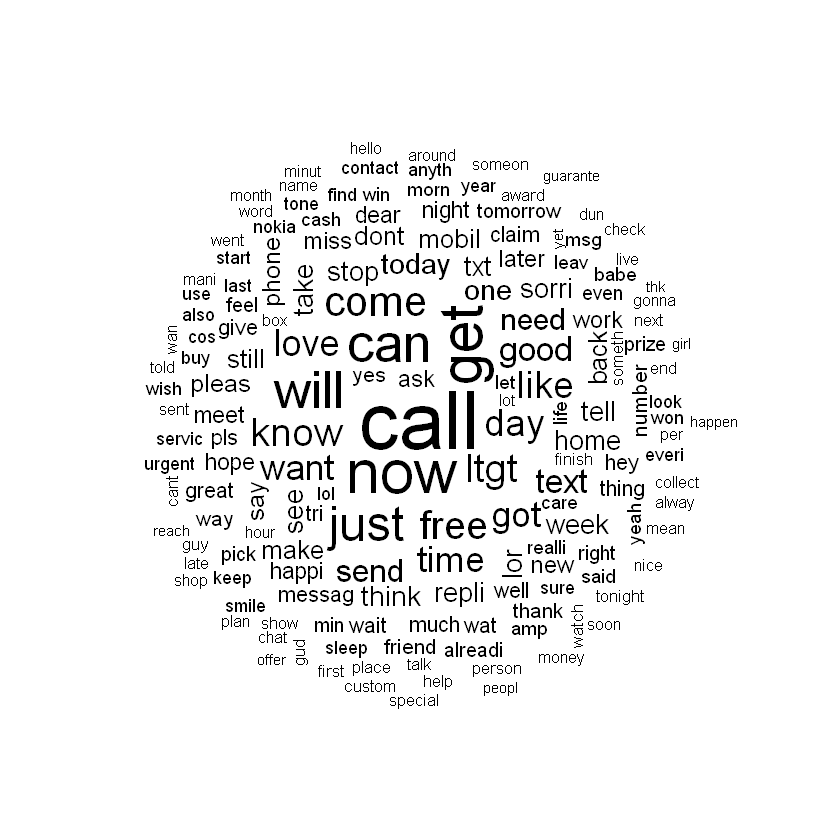

In [30]:
library(wordcloud)

wordcloud(sms_corpus_clean, min.freq = 50, random.order = FALSE)

***Step 3 - Data Preparation - Splitting Text Documents into Words***

Now that the data are processed to our liking, the final step is to split the messages
into individual components through a process called tokenization. A token is a
single element of a text string; in this case, the tokens are words. The tm package provides functionality to tokenize the SMS message corpus. The DocumentTermMatrix() function will take a corpus and create
a data structure called a Document Term Matrix (DTM) in which rows indicate
documents (SMS messages) and columns indicate terms (words).

In [31]:
sms_dtm <- DocumentTermMatrix(sms_corpus_clean)
sms_dtm

<<DocumentTermMatrix (documents: 5574, terms: 6611)>>
Non-/sparse entries: 42653/36807061
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

[Aggiungere Esempio]

The differences between these two cases illustrate an important principle of cleaning
text data: **the order of operations matters**. With this in mind, it is very important
to think through how early steps in the process are going to affect later ones. The
order presented here will work in many cases, but when the process is tailored more
carefully to specific datasets and use cases, it may require rethinking. For example,
if there are certain terms you hope to exclude from the matrix, consider whether you
should search for them before or after stemming. Also, consider how the removal
of punctuation—and whether the punctuation is eliminated or replaced by blank
space—affects these steps.

***Step 4 - Data Preparation - Creating Training and Test Datasets***






In [32]:
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test  <- sms_dtm[4170:5559, ]

In [33]:
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels  <- sms_raw[4170:5559, ]$type

To confirm that the subsets are representative of the complete set of SMS data, let's
compare the proportion of spam in the training and test data frames:

In [34]:
prop.table(table(sms_train_labels))

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

In [35]:
prop.table(table(sms_test_labels))

sms_test_labels
      ham      spam 
0.8697842 0.1302158 

In [36]:
spam <- subset(sms_raw, type == "spam")
ham <- subset(sms_raw, type == "ham")

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"

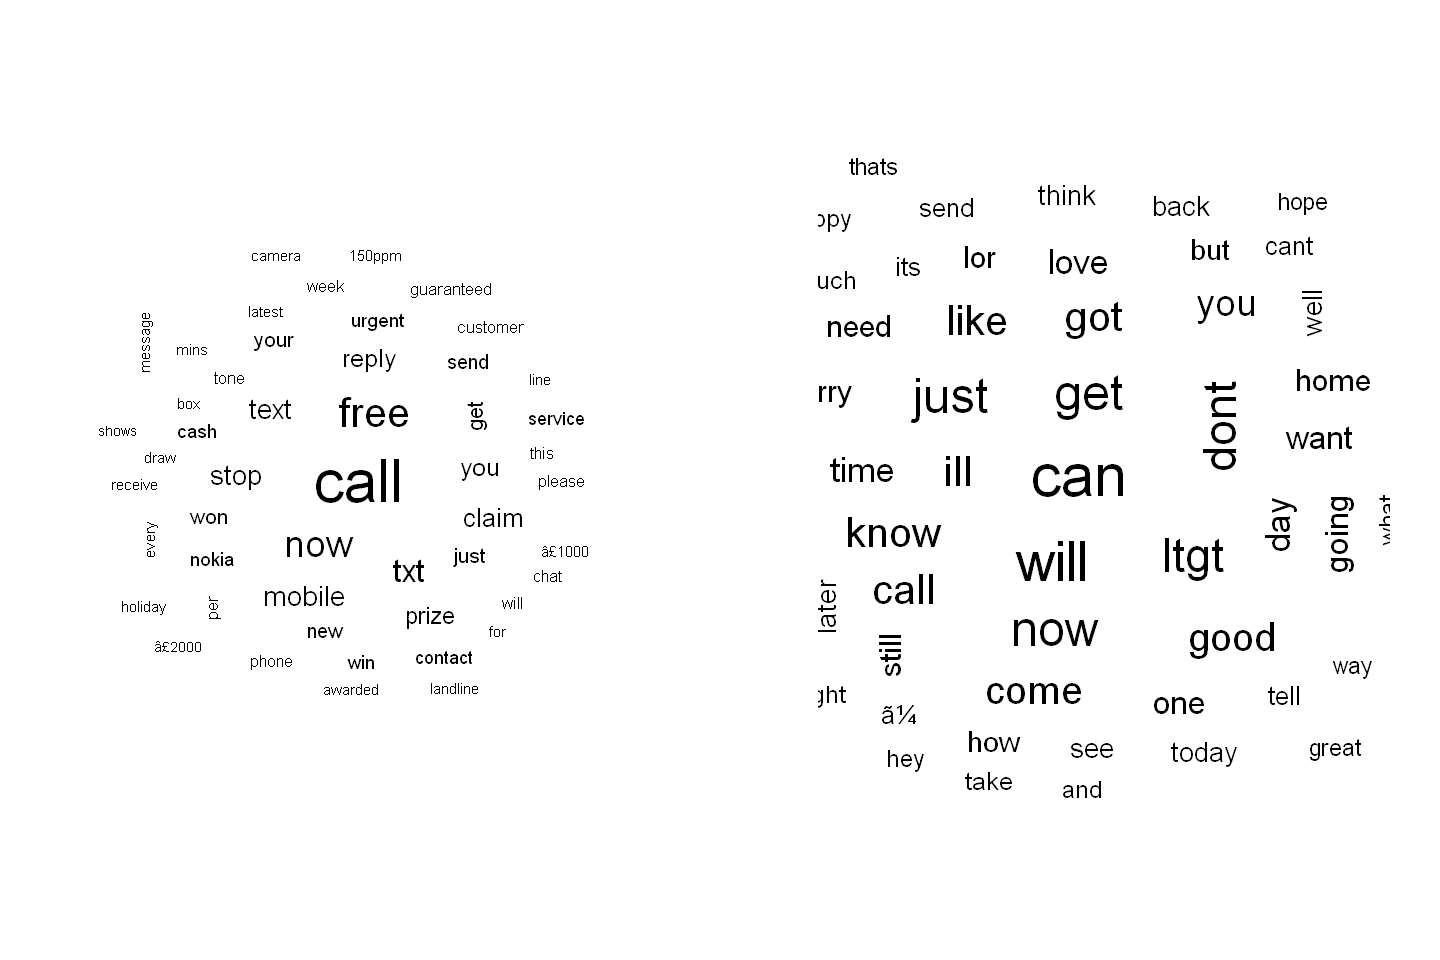

In [38]:
#options(warn=-1)
library(stringr)
#
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow=c(1, 2))
#
# la chiamata seguente serve ad eliminare tutti i simboli grafici dal testo
# vedi : https://stackoverflow.com/questions/9637278/r-tm-package-invalid-input-in-utf8towcs 
#
usableTextSpam <- str_replace_all(spam$text,"[^[:graph:]]", " ") 
usableTextHam  <- str_replace_all(ham$text,"[^[:graph:]]", " ") 

wordcloud(usableTextSpam, max.words = 50, scale = c(3, 0.5), random.color=TRUE, random.order = FALSE)
wordcloud(usableTextHam,  max.words = 50, scale = c(3, 0.5), random.color=TRUE, random.order = FALSE)

***Step 5 - Data Preparation - Creating Indicator Features for Frequent Words***

The final step in the data preparation process is to transform the sparse matrix into a
data structure that can be used to train a Naive Bayes classifier. Currently, the sparse
matrix includes over 6,500 features; this is a feature for every word that appears in at
least one SMS message. It's unlikely that all of these are useful for classification. To
reduce the number of features, we will eliminate any word that appear in less than five
SMS messages, or in less than about 0.1 percent of the records in the training data.
Finding frequent words requires use of the `findFreqTerms()` function in the
tm package. This function takes a DTM and returns a character vector containing
the words that appear for at least the specified number of times. For instance,
the following command will display the words appearing at least five times in
the sms_dtm_train matrix:

In [39]:
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)

We now need to filter our DTM to include only the terms appearing in a specified
vector. As done earlier, we'll use the data frame style `[row, col]` operations to
request specific portions of the DTM, noting that the columns are named after the
words the DTM contains. We can take advantage of this to limit the DTM to specific
words. Since we want all the rows, but only the columns representing the words in
the `sms_freq_words vector`, our commands are:

In [40]:
sms_dtm_freq_train <- sms_dtm_train[ , sms_freq_words]
sms_dtm_freq_test  <- sms_dtm_test [ , sms_freq_words]

In [41]:
convert_counts <- function(x) {
    x <- ifelse(x > 0, "Yes", "No")
}

In [42]:
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test  <- apply(sms_dtm_freq_test,  MARGIN = 2, convert_counts)

***Step 6 - Training a Model on the Data***

In [44]:
library(e1071)

sms_classifier <- naiveBayes(sms_train, sms_train_labels)

In [ ]:
sms_test_pred <- predict(sms_classifier, sms_test)

**Example: Document Cluster**